Wczytanie danych

In [1]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(plyr)


#wczytanie z pliku
df <- read.csv(file="data_ecg.csv", dec='.', sep=';')
#ustalenie typu w kolumnie
df$duration  <- as.factor(df$duration)
#sprawdzanie czy wszystko zadziałało jak powinno
head(df)
#"podsumowanie" danych
summary(df)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



participant,sound,duration,Td,K6,Rd,A2,V2
MZ078,CEGis,1300,1300,0P,1955,DI,DI
MG082,CEGis,1300,1300,0P,1383,DI,DI
KS119,CEGis,1300,1300,0P,1486,DI,DI
MF088,CEGis,1300,1300,0P,2037,DI,DI
KM066,CEGis,1300,1300,0P,1599,DI,DI
KK105,CEGis,1300,1300,0P,2429,DI,DI


  participant     sound      duration          Td        K6      
 AC108  : 144   CEG  :2959   1300:2214   Min.   :1300   0P:1075  
 AG080  : 144   CEGis:2954   1800:2212   1st Qu.:1800   PQ:1226  
 AG122  : 144   CEsG :2947   2300:2215   Median :2300   QR: 348  
 AS099  : 144                2800:2219   Mean   :2051   RS: 372  
 BG073  : 144                            3rd Qu.:2800   ST:2427  
 DDR103 : 144                            Max.   :2800   T0:3412  
 (Other):7996                                                    
       Rd          A2         V2      
 Min.   :  238   DI :7286   DI :6061  
 1st Qu.: 1868   SYS:1574   SYS:2799  
 Median : 2426                        
 Mean   : 2551                        
 3rd Qu.: 2985                        
 Max.   :11969                        
                                      

Dodanie kolumny z błędem bezwzględnym AE = |Rd - duration|/duartion oraz Ratio = Rd/duration

In [2]:
df['AE'] = abs(df$Rd - df$Td)/df$Td
df['Ratio'] = df$Rd/df$Td
head(df, 10)


participant,sound,duration,Td,K6,Rd,A2,V2,AE,Ratio
MZ078,CEGis,1300,1300,0P,1955,DI,DI,0.50384615,1.5038462
MG082,CEGis,1300,1300,0P,1383,DI,DI,0.06384615,1.0638462
KS119,CEGis,1300,1300,0P,1486,DI,DI,0.14307692,1.1430769
MF088,CEGis,1300,1300,0P,2037,DI,DI,0.56692308,1.5669231
KM066,CEGis,1300,1300,0P,1599,DI,DI,0.23000000,1.2300000
KK105,CEGis,1300,1300,0P,2429,DI,DI,0.86846154,1.8684615
DO084,CEGis,1300,1300,0P,3086,DI,DI,1.37384615,2.3738462
AG111,CEGis,1300,1300,0P,1271,DI,DI,0.02230769,0.9776923
PP102,CEGis,1300,1300,0P,925,DI,DI,0.28846154,0.7115385
AS099,CEGis,1300,1300,0P,4004,DI,DI,2.08000000,3.0800000


Stworzenie oddzielnej dataframe, z kolumną CV

In [3]:
agg_df <- ddply(df, .(participant, sound, duration, A2), 
                  summarize, 
                  Rd.mean=mean(Rd, na.rm=TRUE), 
                  Td.mean=mean(Td,na.rm=TRUE), 
                  Rd.sd = sd(Rd, na.rm=TRUE))

agg_df <- mutate(agg_df, CV = Rd.sd/Rd.mean)
agg_df['CV'] = agg_df['Rd.sd']/agg_df['Rd.mean']
agg_df$CV = agg_df$Rd.sd / agg_df$Rd.mean

head(agg_df)

participant,sound,duration,A2,Rd.mean,Td.mean,Rd.sd,CV
AB107,CEG,1300,DI,1778.778,1300,381.8736,0.2146831
AB107,CEG,1300,SYS,1905.333,1300,320.4642,0.1681933
AB107,CEG,1800,DI,2609.182,1800,293.5353,0.1125009
AB107,CEG,1800,SYS,2623.000,1800,NA,NA
AB107,CEG,2300,DI,2533.727,2300,385.4634,0.1521329
AB107,CEG,2800,DI,3036.300,2800,480.9329,0.1583944


Inne przykłady agregowania/grupowania danych

In [4]:
agg_sample <- ddply(df, .(participant), 
                  summarize, 
                  AE.max=max(AE))
head(agg_sample)
agg_sample <- ddply(df, .(participant, sound), 
                  summarize, 
                  Td.sum=sum(Td,na.rm=TRUE))
head(agg_sample)

participant,AE.max
AB107,1.0476923
AB121,0.7215385
AB123,5.5623077
AC108,0.9000000
AC116,2.9223077
AG080,0.5400000


participant,sound,Td.sum
AB107,CEG,96100
AB107,CEGis,98400
AB107,CEsG,98400
AB121,CEG,98400
AB121,CEGis,96100
AB121,CEsG,97100


ANOVA teoretycznie wymaga od danych spełnienie dwóch warunków:
1. Rozkład zmiennej badanej jest normalny (test shapiro-wilka)
2. Jednorodność wariancji (test Levene'a)

In [5]:
Rysowanie histogramów

ERROR: Error in parse(text = x, srcfile = src): <text>:1:11: unexpected symbol
1: Rysowanie histogramów
              ^


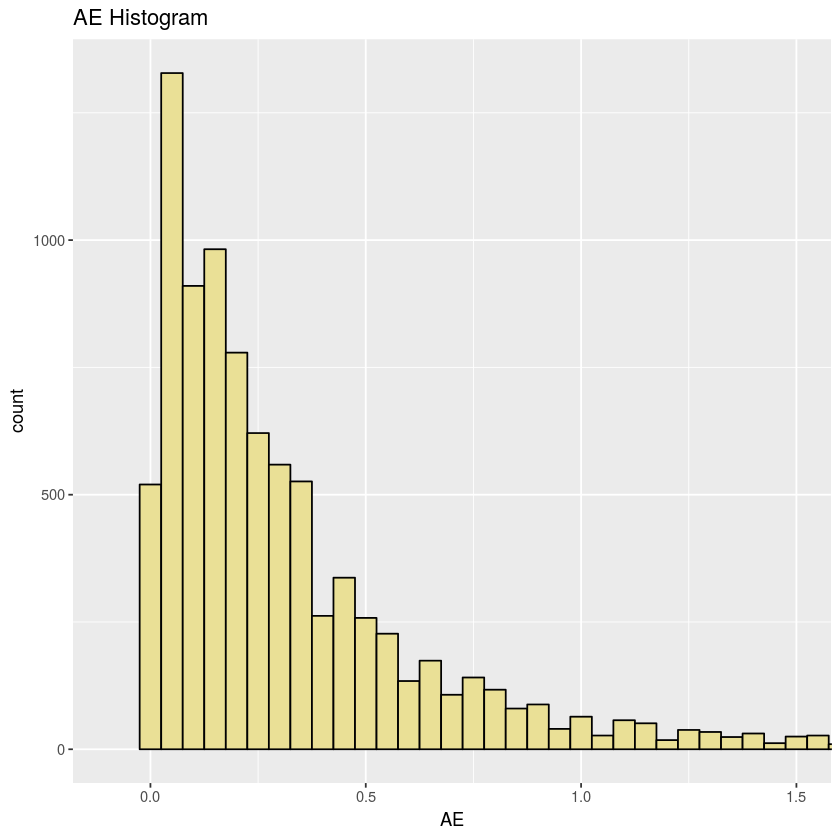

In [6]:
ggplot(df, aes(x=AE)) + 
    geom_histogram(binwidth=0.05, color='black', fill='#eae096') +
    coord_cartesian(xlim=c(-0.1,1.5)) +
    labs(title="AE Histogram")

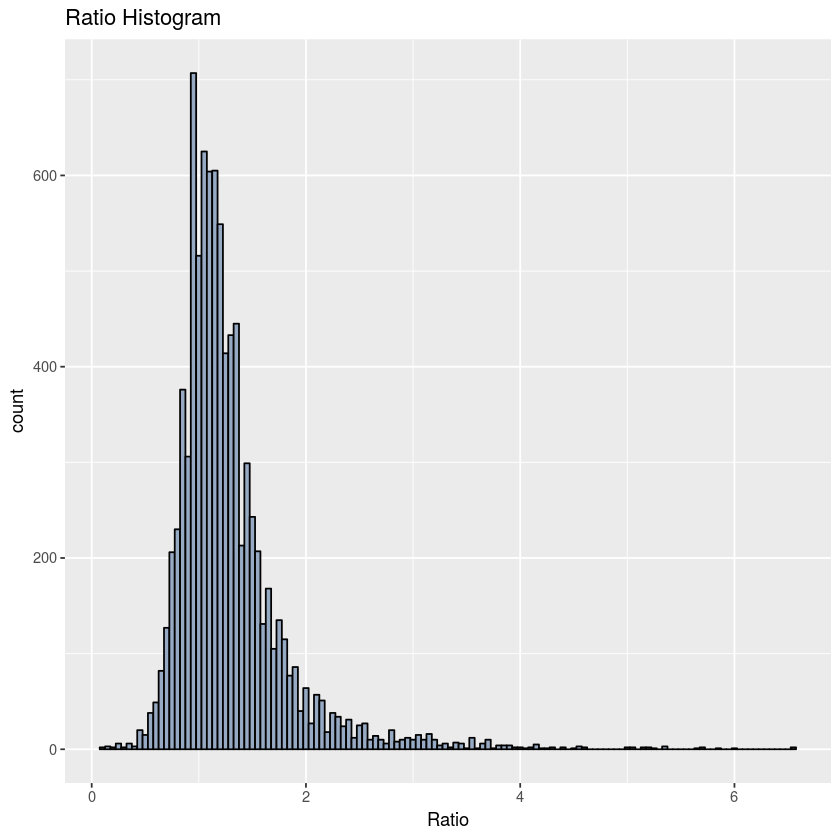

In [7]:
ggplot(df, aes(x=Ratio)) +
    geom_histogram(binwidth=0.05, color='black', fill='#97aac4') +
    labs(title="Ratio Histogram")

Warning message:
“Removed 194 rows containing non-finite values (stat_bin).”

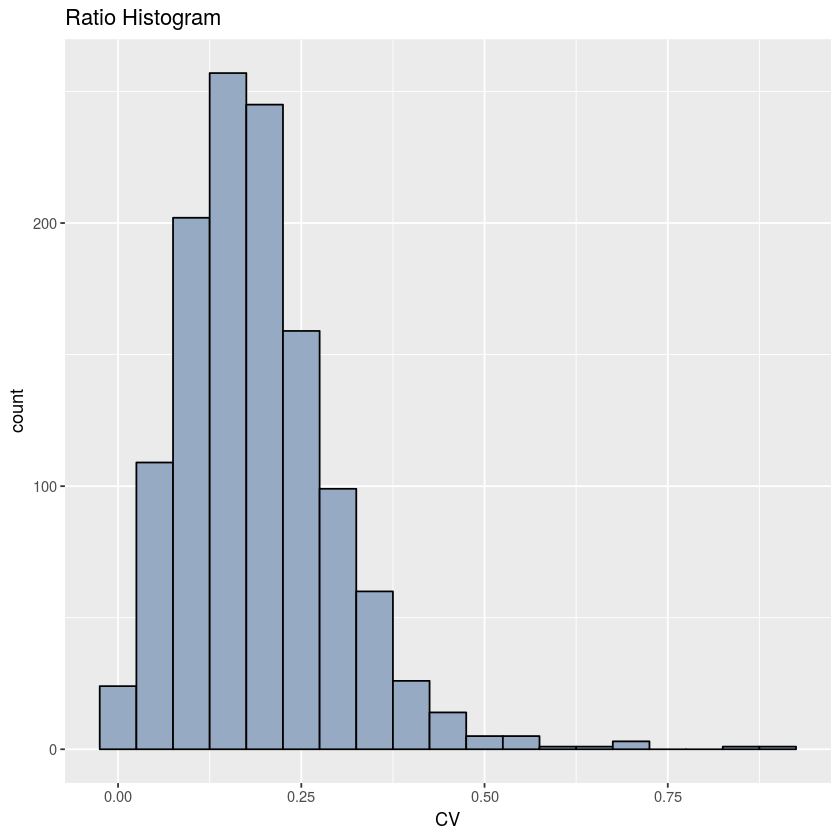

In [8]:
ggplot(agg_df, aes(x=CV)) +
    geom_histogram(binwidth=0.05, color='black', fill='#97aac4') +
    labs(title="Ratio Histogram")

Test Shapiro-Wilka

In [9]:
#funkcja sample wybiera X losowych wartości
AEshapiro <- shapiro.test(df[sample(nrow(df), 4900), 'AE'])
RatioShapiro <- shapiro.test(df[sample(nrow(df), 4900), 'Ratio'])

AEshapiro
RatioShapiro


	Shapiro-Wilk normality test

data:  df[sample(nrow(df), 4900), "AE"]
W = 0.63957, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  df[sample(nrow(df), 4900), "Ratio"]
W = 0.7823, p-value < 2.2e-16


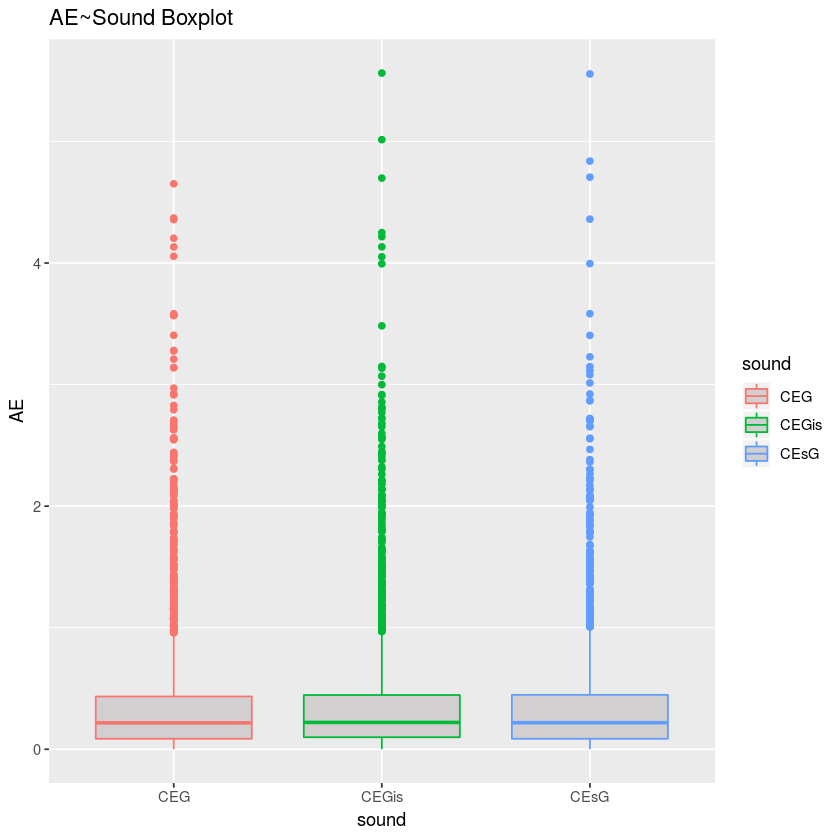

Saving 6.67 x 6.67 in image


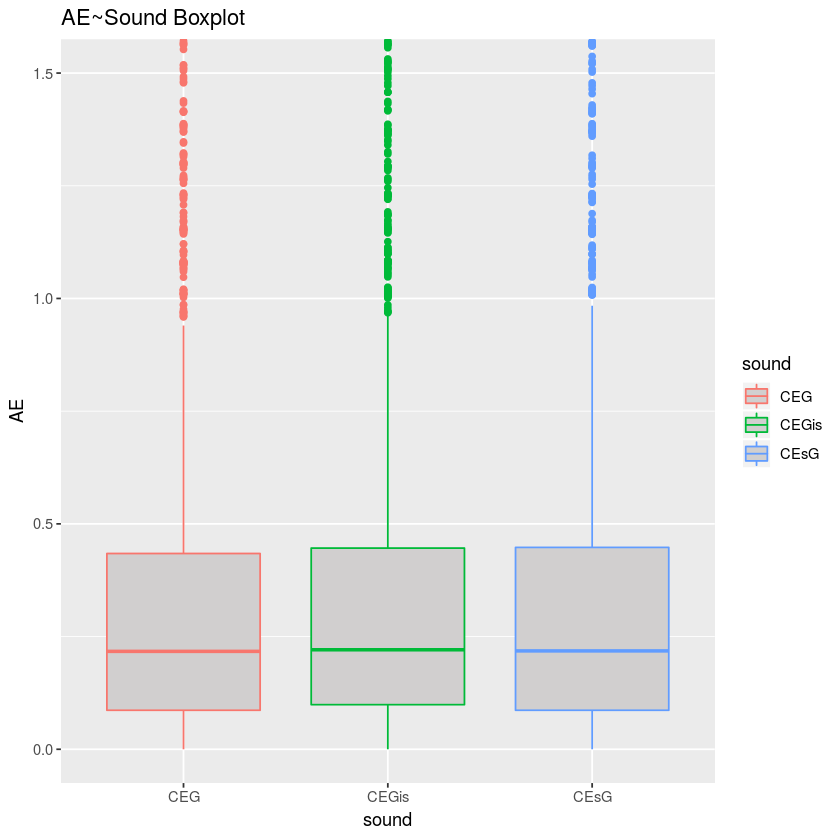

In [10]:
#bez ograniczenia osi y (bez "przybliżania")
kappa <- ggplot(df, aes(y=AE, x=sound, color=sound)) +
    geom_boxplot(fill='#d1cfcf') +
    labs(title="AE~Sound Boxplot", xlabel="Sound")  
kappa
kappa + coord_cartesian(ylim=c(0,1.5)) 


#zapisywanie ostatniego wykresu do pliku
ggsave('AE~Sound.pdf')

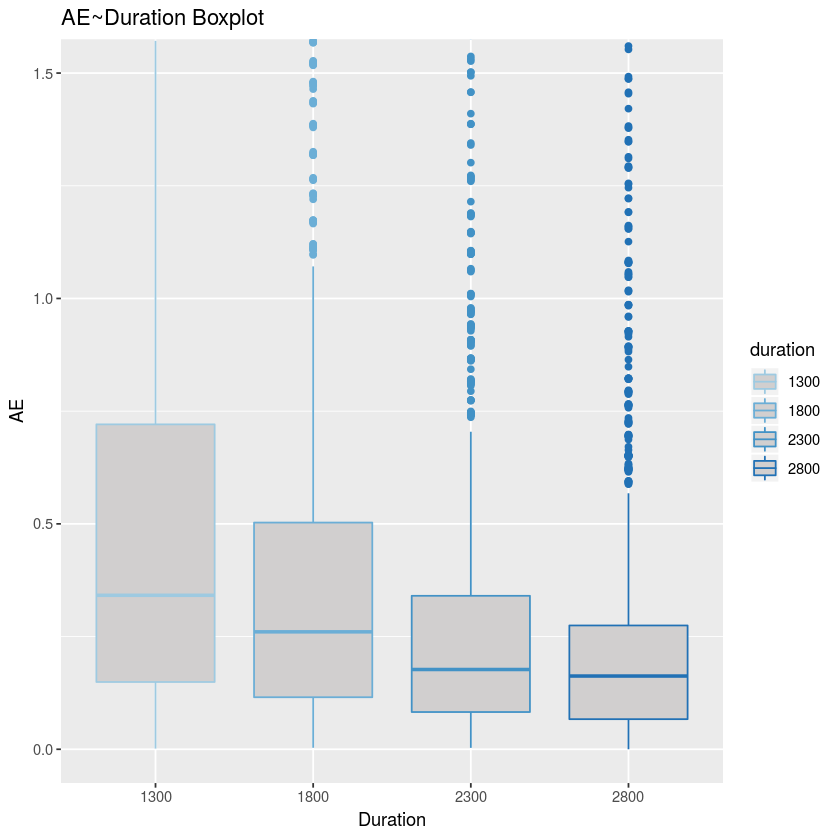

In [11]:
my_blues = brewer.pal(n = 9, "Blues")[4:9]

ggplot(df, aes(y=AE, x=duration, color=duration)) +
    coord_cartesian(ylim=c(0,1.5)) +
    geom_boxplot(fill='#d1cfcf') +
    labs(title="AE~Duration Boxplot") +
    scale_color_manual(values=my_blues) +
    xlab('Duration')

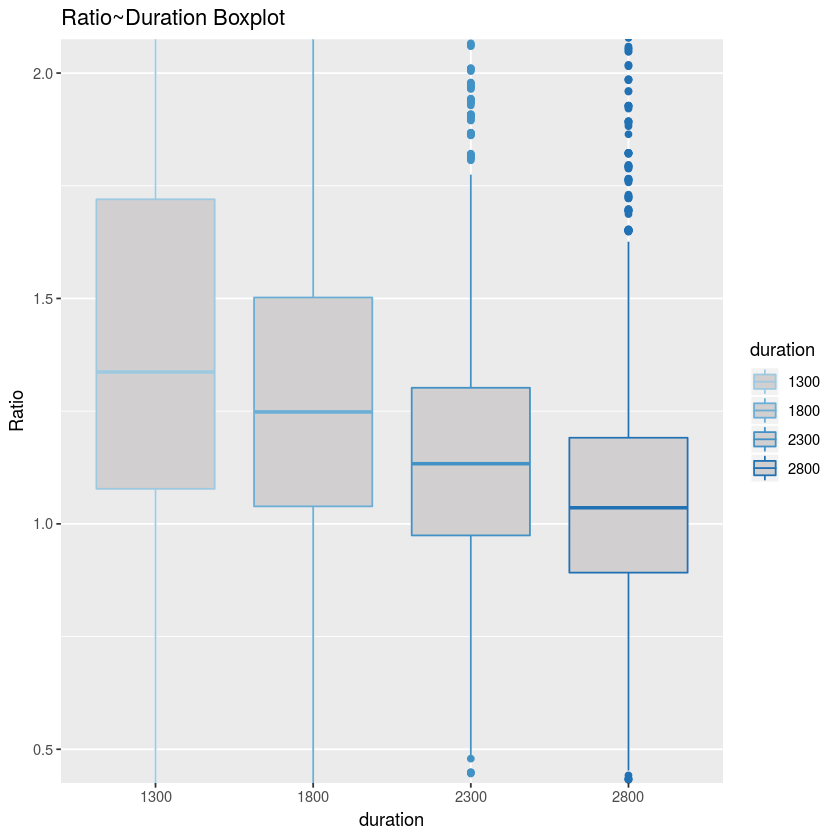

In [12]:
ggplot(df, aes(y=Ratio, x=duration, color=duration)) +
    coord_cartesian(ylim=c(0.5,2)) +
    geom_boxplot(fill='#d1cfcf') +
    labs(title="Ratio~Duration Boxplot") +
    scale_color_manual(values=my_blues)

Warning message:
“Removed 194 rows containing non-finite values (stat_boxplot).”

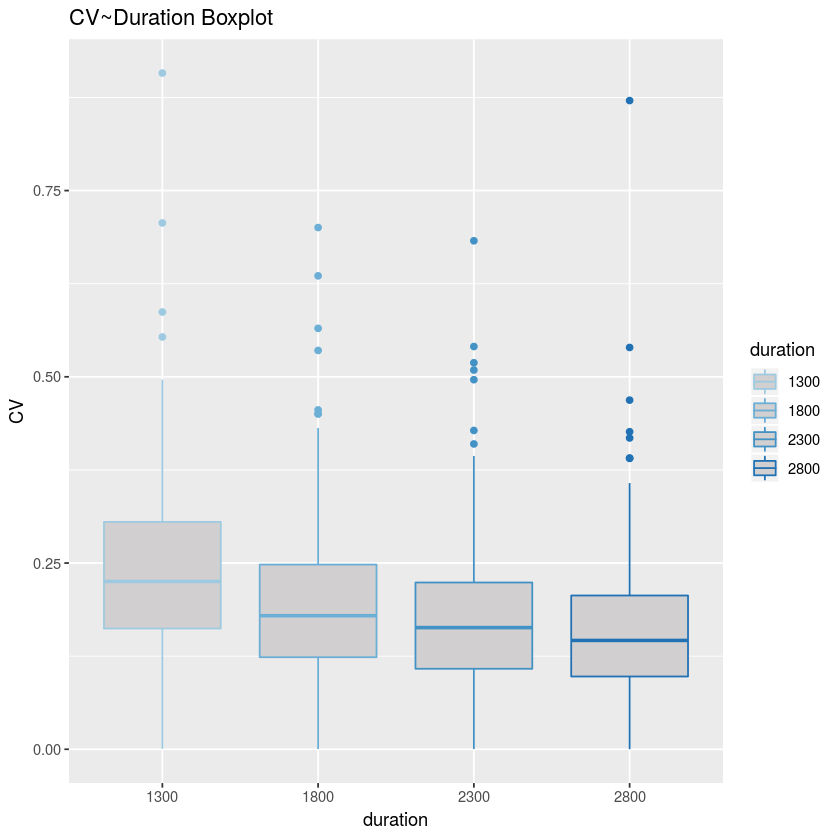

In [13]:
ggplot(agg_df, aes(y=CV, x=duration, color=duration)) +
    geom_boxplot(fill='#d1cfcf') +
    labs(title="CV~Duration Boxplot") +
    scale_color_manual(values=my_blues)

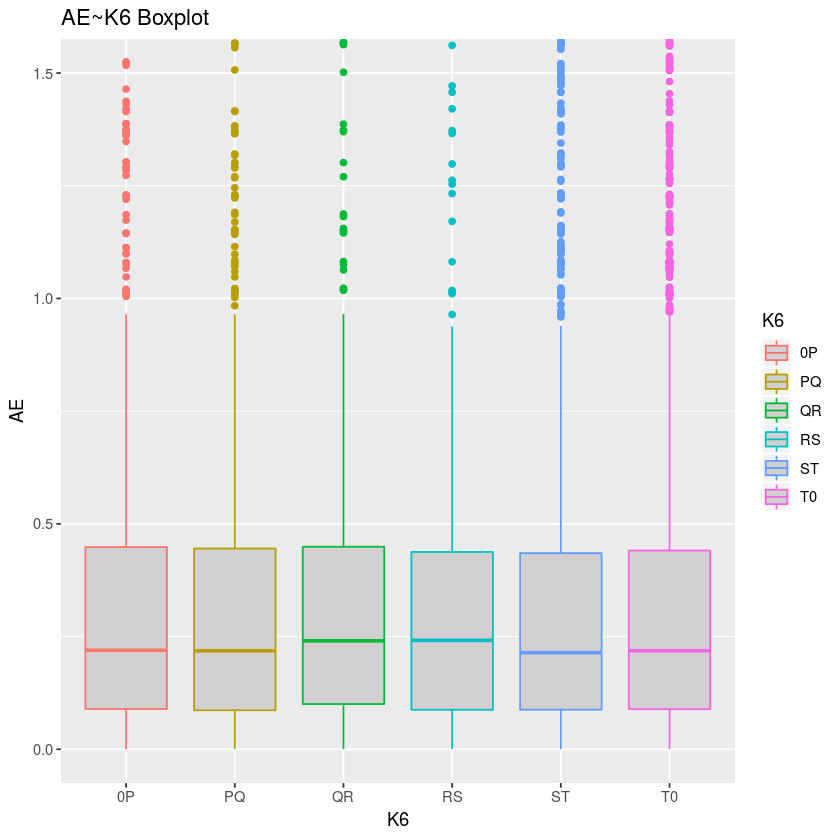

In [14]:
ggplot(df, aes(y=AE, x=K6, color=K6)) +
    coord_cartesian(ylim=c(0,1.5)) +
    geom_boxplot(fill='#d1cfcf') +
    labs(title="AE~K6 Boxplot")

In [15]:
ANOVA_AE <- aov(AE ~ K6+duration+sound+A2, data=df)
# ANOVA clustrowanie
ANOVA_AEE <- aov(AE ~ K6*duration*sound, data=df)
ANOVA_Ratio <- aov(Ratio ~ K6+duration+sound+A2, data=df)
ANOVA_CV <- aov(CV ~ duration+sound, data=agg_df)

In [16]:
summary(ANOVA_AE)
summary(ANOVA_AEE)

              Df Sum Sq Mean Sq F value Pr(>F)    
K6             5    0.7    0.13   0.604  0.697    
duration       3  124.2   41.39 192.260 <2e-16 ***
sound          2    0.2    0.09   0.402  0.669    
Residuals   8849 1905.1    0.22                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df Sum Sq Mean Sq F value Pr(>F)    
K6                   5    0.7    0.13   0.605  0.696    
duration             3  124.2   41.39 192.527 <2e-16 ***
sound                2    0.2    0.09   0.402  0.669    
K6:duration         15    4.1    0.28   1.287  0.201    
K6:sound            10    2.7    0.27   1.272  0.240    
duration:sound       6    0.3    0.04   0.203  0.976    
K6:duration:sound   30    8.6    0.29   1.335  0.104    
Residuals         8788 1889.3    0.21                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [17]:
summary(ANOVA_Ratio)
summary(ANOVA_CV)

              Df Sum Sq Mean Sq F value Pr(>F)    
K6             5    0.8    0.16   0.630  0.677    
duration       3  198.3   66.09 253.278 <2e-16 ***
sound          2    0.4    0.18   0.695  0.499    
Residuals   8849 2309.2    0.26                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq F value Pr(>F)    
duration       3   0.95  0.3167  30.117 <2e-16 ***
sound          2   0.00  0.0001   0.008  0.992    
Residuals   1206  12.68  0.0105                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
194 observations deleted due to missingness